# Ensemble learning

## 1. Review for Decision Tree

- Representation: Tree that splits data points into leaves based on tests
* Evaluation (loss): Heuristic for purity of leaves (Gini index, entropy,...)
* Optimization: Recursive, heuristic greedy search (Hunt's algorithm)
    * Consider all splits (thresholds) between adjacent data points, for every feature
    * Choose the one that yields the purest leafs, repeat

### 1.1. Evaluation (loss function for classification)
* Every leaf predicts a class probability $\hat{p}_c$ = the relative frequency of class $c$
* Leaf impurity measures (splitting criteria) for $L$ leafs, leaf $l$ has data $X_l$:
    - Gini-Index: $Gini(X_{l}) = \sum_{c\neq c'} \hat{p}_c \hat{p}_{c'}$
    - Entropy (more expensive): $E(X_{l}) = -\sum_{c\neq c'} \hat{p}_c \log_{2}\hat{p}_c$
    - Best split maximizes _information gain_ (idem for Gini index) $$ Gain(X,X_i) = E(X) - \sum_{l=1}^L \frac{|X_{i=l}|}{|X_{i}|} E(X_{i=l}) $$


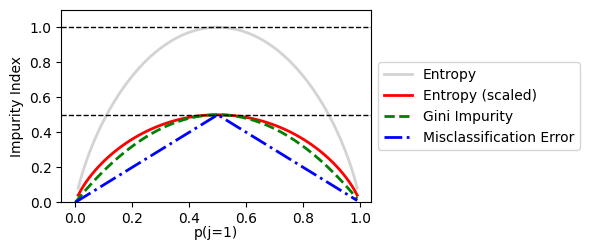

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def classification_error(p):
   return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
scaled_ent = [e*0.5 if e else None for e in ent]
c_err = [classification_error(i) for i in x]

fig_scale = 1
fig = plt.figure(figsize=(5*fig_scale, 2.5*fig_scale))
ax = plt.subplot(111)

for j, lab, ls, c, in zip(
      [ent, scaled_ent, gini(x), c_err],
      ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'],
      ['-', '-', '--', '-.'],
      ['lightgray', 'red', 'green', 'blue']):
   line = ax.plot(x, j, label=lab, linestyle=ls, lw=2*fig_scale, color=c)

ax.legend(loc='upper left', ncol=1, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylim([0, 1.1])
plt.xlabel('p(j=1)',labelpad=0)
plt.ylabel('Impurity Index')
plt.show()

### 1.2. Regression trees
* Every leaf predicts the _mean_ target value $\mu$ of all points in that leaf
* Choose the split that minimizes squared error of the leaves: $\sum_{x_{i} \in L} (y_i - \mu)^2$
* Yields non-smooth step-wise predictions, cannot extrapolate

### 1.3. Impurity/Entropy-based feature importance

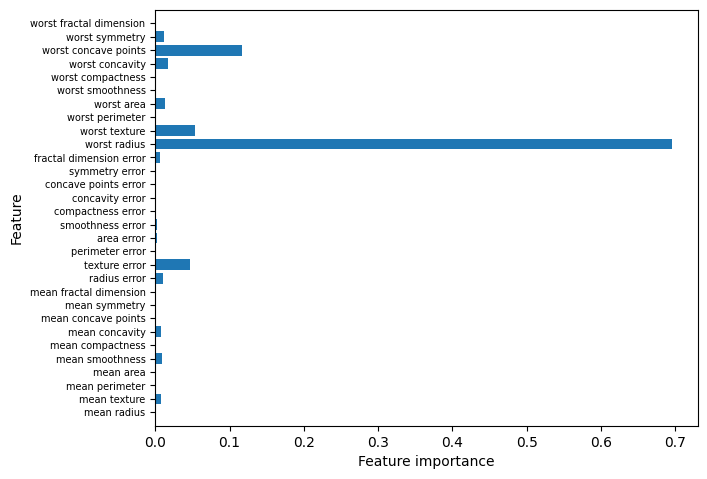

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
Xc_train, Xc_test, yc_train, yc_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0).fit(Xc_train, yc_train)

def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.figure(figsize=(7*fig_scale,5.4*fig_scale))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names, fontsize=7)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
plot_feature_importances_cancer(tree)

## 2. Ensemble learning

* If different models make different mistakes, can we simply average the predictions?
* Voting Classifier: gives every model a _vote_ on the class label
    * Hard vote: majority class wins (class order breaks ties)
    * Soft vote: sum class probabilities $p_{m,c}$ over $M$ models: $\underset{c}{\operatorname{argmax}} \sum_{m=1}^{M} w_c p_{m,c}$
    * Classes can get different weights $w_c$ (default: $w_c=1$)

* Why does this work?
    * Different models may be good at different 'parts' of data (even if they underfit)
    * Individual mistakes can be 'averaged out' (especially if models overfit)


* We can easily control the (maximum) depth of the trees as a hyperparameter
* Bias-variance analysis:
    * Shallow trees have high bias but very low variance (underfitting)
    * Deep trees have high variance but low bias (overfitting)
* Because we can easily control their complexity, they are ideal for ensembling
    * Deep trees: keep low bias, reduce variance with **_Bagging_**
    * Shallow trees: keep low variance, reduce bias with **_Boosting_**

### 2.1. Bagging (Bootstrap Aggregating)

Obtain **different models** by training **the same model** on **different training samples**

- Reduce overfitting by averaging out individual predictions (variance reduction)

In practice: take $I$ bootstrap samples of your data, train a model on each bootstrap

- Higher $I$: more models, more smoothing (but slower training and prediction)


Base models should be **unstable**: different training samples yield different models

- E.g. very deep decision trees, or even randomized decision trees

- Deep Neural Networks can also benefit from bagging (deep ensembles)

Prediction by averaging predictions of base models

- Soft voting for classification (possibly weighted)

- Mean value for regression

Can produce uncertainty estimates as well

- By combining class probabilities of individual models (or variances for regression)

#### 2.1.1. Random Forest in Sk-learn

* Different implementations can be used. E.g. in scikit-learn:
    * `BaggingClassifier`: Choose your own base model and sampling procedure
    * `RandomForestClassifier`: Default implementation, many options
    * `ExtraTreesClassifier`: Uses extremely randomized trees

* Most important parameters:
    * `n_estimators` (>100, higher is better, but diminishing returns)
        * Will start to underfit (bias error component increases slightly)
    * `max_features`
        * Defaults: $sqrt(p)$ for classification, $log2(p)$ for regression
        * Set smaller to reduce space/time requirements
    * parameters of trees, e.g. `max_depth`, `min_samples_split`,...
        * Prepruning useful to reduce model size, but don't overdo it

* Easy to parallelize (set `n_jobs` to -1)
* Fix `random_state` (bootstrap samples) for reproducibility 

#### 2.1.2. Effect on bias and variance

- Increasing the number of models (trees) decreases variance (less overfitting)
    - Bias is mostly unaffected, but will increase if the forest becomes too large (oversmoothing)


### 2.2. Boosting

通过顺序训练多个模型, 每个模型都试图纠正前一个模型的错误. 每次训练时, 给予之前错误分类的样本更高的权重, 从而集中学习难以分类的样本.
- 优点: 提高模型的准确性, 能显著减少bias.


#### 2.2.1 AdaBoosting

#### 2.2.2. GradientBoosting

#### 2.2.3. Extreme Gradient Boosting (XGBoost)

#### 2.2.4. LightGBM

#### 2.2.5. CatBoost

### 2.3. Stacking